# Label Maker

Explanation: Form Labels by all the various measures we have  
  
Changes:  
6/13/2019 I changed 'Ratio' to 'RUA_Close' in Label1

In [16]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [17]:
# Load dataset
path = '../Data/Sharpe_RUA_complete.csv'
master = pd.read_csv(path)
master = master[pd.isnull(master['Date']) == False] # remove missing
master.head()

,Unnamed: 0,Date,RUA Close,Risk-Free TNX,RUA_Returns,Dates,Annual_Return_RUA,Numerator,Std_RUA,Ratio,Ratio_smoothed,Unnamed: 11
0,837.0,1/2/91,178.979996,7.97,-0.010395,1/2/91,0.094524,0.014824,2.256054,0.006571,0.008547,-0.001976
1,838.0,1/3/91,176.639999,7.93,-0.013074,1/3/91,0.079362,0.000062,2.234674,0.000028,0.008775,-0.008747
2,839.0,1/4/91,176.259995,8.02,-0.002151,1/4/91,0.074637,-0.005563,2.216556,-0.002510,0.009003,-0.011513
3,840.0,1/7/91,173.199997,8.13,-0.017361,1/7/91,0.085293,0.003993,2.154587,0.001853,0.009232,-0.007379
4,841.0,1/8/91,172.779999,8.16,-0.002425,1/8/91,0.084374,0.002774,2.154293,0.001288,0.009460,-0.008172


### Create a datetime column

In [18]:
dates = master['Date'].values
datetime_list = []

for i in range(master.shape[0]):

    date = datetime.strptime(dates[i], '%m/%d/%y')
    datetime_list.append(date)

master['Datetimes'] = datetime_list

### Exponential Moving Average Function

In [19]:
def ema(df):
    n = df.shape[0] # number of elements
    multiplier = (n * (n + 1)) / 2
    average = 0
    ratios = df['Ratio'].values

    for idx in range(0,n): # reversed
        #print(idx+1, multiplier)
        average = average + (ratios[idx] * (idx+1) /multiplier)
    
    #print(average)
    return average

In [20]:
from sklearn.mixture import GaussianMixture
# AIC

def AIC(X):
    model = GaussianMixture(n_components=n_clusters, init_params='kmeans')
    model.fit(X)
    print(model.aic(X))
    return model.aic(X)

## Label 1:
Predict increase (class 1) vs decrease (class 2) of SI(t+m) compared to SI(t)  
* Based on Smoothed Ratio  
* Disadvantage: Our smoothed ratio is based on retrospective knowledge that we already have

In [21]:
# Hyperparameters
m = 60 # m days in advance

In [22]:
labels1 = []
future_date = []
future_RUA = []

for i in range(master.shape[0]):
    label_date = master.loc[i]['Datetimes'] + timedelta(days = m)
    subset = master[master['Datetimes'] >= label_date]
    try:
        future_sharpe = subset.iloc[0]['RUA Close'] # iloc ignores index but loc does not ALT: Ratio_smoothed
        future_date.append(subset.iloc[0]['Date'])
        future_RUA.append(subset.iloc[0]['RUA Close'])
    except:
        labels1.append(np.nan)
        future_date.append(4)
        future_RUA.append(4)
        continue
    if master.loc[i]['RUA Close'] <= future_sharpe: # ALT: Ratio_smoothed
        labels1.append(1)
    else:
        labels1.append(0)
print(len(future_date), len(future_RUA), len(labels1))
master['Label1_m30'] = np.array(labels1).astype('int')
master['FutureDate'] = future_date
master['FutureRUA'] = future_RUA

7140 7140 7140


In [23]:
master.head()

,Unnamed: 0,Date,RUA Close,Risk-Free TNX,RUA_Returns,Dates,Annual_Return_RUA,Numerator,Std_RUA,Ratio,Ratio_smoothed,Unnamed: 11,Datetimes,Label1_m30,FutureDate,FutureRUA
0,837.0,1/2/91,178.979996,7.97,-0.010395,1/2/91,0.094524,0.014824,2.256054,0.006571,0.008547,-0.001976,1991-01-02,1,3/4/91,204.539993
1,838.0,1/3/91,176.639999,7.93,-0.013074,1/3/91,0.079362,0.000062,2.234674,0.000028,0.008775,-0.008747,1991-01-03,1,3/4/91,204.539993
2,839.0,1/4/91,176.259995,8.02,-0.002151,1/4/91,0.074637,-0.005563,2.216556,-0.002510,0.009003,-0.011513,1991-01-04,1,3/5/91,208.529999
3,840.0,1/7/91,173.199997,8.13,-0.017361,1/7/91,0.085293,0.003993,2.154587,0.001853,0.009232,-0.007379,1991-01-07,1,3/8/91,207.710007
4,841.0,1/8/91,172.779999,8.16,-0.002425,1/8/91,0.084374,0.002774,2.154293,0.001288,0.009460,-0.008172,1991-01-08,1,3/11/91,206.570007


# Label 2:
Predict increase (class 1) vs decrease (class 2) of SI(t+m) vs mean (SI(t-6:t))

In [67]:
# Hyperparameters
m = 30

In [68]:
labels2 = []
for i in range(master.shape[0]):
    label_date = master.loc[i]['Datetimes'] + timedelta(days = m)
    # t + 30 (future time)
    subset = master[master['Datetimes'] >= label_date] # everything that comes at or after the label date
    # 6 days before time t and t (present time)
    subset2 = master[(master['Datetimes'] >= master.loc[i]['Datetimes'] - timedelta(days = 6)) & (master['Datetimes'] <= master.loc[i]['Datetimes'])]
    
    # get the future SI value
    try:
        future_sharpe = subset.iloc[0]['Ratio'] # iloc ignores index but loc does not
        # pick first value because that's the oldest time
        #print(label_date, subset.iloc[0]['Datetimes'])
    except:
        labels2.append(np.nan)
        continue
    
    # get past SI value
    try:
        past_sharpe = np.mean(subset2['Ratio'].values)
    except:
        labels2.append(np.nan)
        continue
    
    if past_sharpe <= future_sharpe:
        labels2.append(1)
    else:
        labels2.append(0)

print(len(labels2))
print(master.shape)
master['Label2'] = np.array(labels2).astype('int')

7140
(7140, 14)


In [69]:
master.head()

,Unnamed: 0,Date,RUA Close,Risk-Free TNX,RUA_Returns,Dates,Annual_Return_RUA,Numerator,Std_RUA,Ratio,Ratio_smoothed,Unnamed: 11,Datetimes,Label1_m30,Label2
0,837.0,1/2/91,178.979996,7.97,-0.010395,1/2/91,0.094524,0.014824,2.256054,0.006571,0.008547,-0.001976,1991-01-02,1,1
1,838.0,1/3/91,176.639999,7.93,-0.013074,1/3/91,0.079362,0.000062,2.234674,0.000028,0.008775,-0.008747,1991-01-03,1,1
2,839.0,1/4/91,176.259995,8.02,-0.002151,1/4/91,0.074637,-0.005563,2.216556,-0.002510,0.009003,-0.011513,1991-01-04,1,1
3,840.0,1/7/91,173.199997,8.13,-0.017361,1/7/91,0.085293,0.003993,2.154587,0.001853,0.009232,-0.007379,1991-01-07,1,1
4,841.0,1/8/91,172.779999,8.16,-0.002425,1/8/91,0.084374,0.002774,2.154293,0.001288,0.009460,-0.008172,1991-01-08,1,1


# Label 3:
Predict increase (class 1) vs decrease (class 2) of SI(t:t+m) vs mean (SI(t-30:t))

In [70]:
# Hyperparameters
m = 30

In [71]:
labels3 = []
save_sharpe = []
for i in range(master.shape[0] - m):
    time_t = master.loc[i]['Datetimes']
    
    label_date = master.loc[i+m]['Datetimes'] #time_t + timedelta(days = m)
    # t: t + 30 (future time)
    subset = master[(master['Datetimes'] >= time_t) & (master['Datetimes'] <= label_date)] # everything that comes at or after the label date
    
    # 30 days before time t and t (the present date)
    subset2 = master[(master['Datetimes'] >= time_t - timedelta(days = m)) & (master['Datetimes'] <= time_t)]

    # get the future SI value
    try:
        future_sharpe = np.mean(subset['Ratio'].values) # iloc ignores index but loc does not
    except:
        labels3.append(np.nan)
        continue
    
    # get past SI value
    try:
        past_sharpe = np.mean(subset2['Ratio'].values)
        save_sharpe.append(past_sharpe)
    except:
        labels3.append(np.nan)
        continue
    
    if past_sharpe <= future_sharpe:
        labels3.append(1)
    else:
        labels3.append(0)

for i in range(m):
    labels3.append(4)
    save_sharpe.append(0)
        
print(len(labels3))
print(master.shape)
master['Label3'] = np.array(labels3).astype('int')
master['Label3_Sharpe'] = np.array(save_sharpe)

7140
(7140, 15)


In [72]:
master.head()

,Unnamed: 0,Date,RUA Close,Risk-Free TNX,RUA_Returns,Dates,Annual_Return_RUA,Numerator,Std_RUA,Ratio,Ratio_smoothed,Unnamed: 11,Datetimes,Label1_m30,Label2,Label3,Label3_Sharpe
0,837.0,1/2/91,178.979996,7.97,-0.010395,1/2/91,0.094524,0.014824,2.256054,0.006571,0.008547,-0.001976,1991-01-02,1,1,1,0.006571
1,838.0,1/3/91,176.639999,7.93,-0.013074,1/3/91,0.079362,0.000062,2.234674,0.000028,0.008775,-0.008747,1991-01-03,1,1,1,0.003299
2,839.0,1/4/91,176.259995,8.02,-0.002151,1/4/91,0.074637,-0.005563,2.216556,-0.002510,0.009003,-0.011513,1991-01-04,1,1,1,0.001363
3,840.0,1/7/91,173.199997,8.13,-0.017361,1/7/91,0.085293,0.003993,2.154587,0.001853,0.009232,-0.007379,1991-01-07,1,1,1,0.001485
4,841.0,1/8/91,172.779999,8.16,-0.002425,1/8/91,0.084374,0.002774,2.154293,0.001288,0.009460,-0.008172,1991-01-08,1,1,1,0.001446


**Note:**
The further out the moving average goes, the less fit it will be to the data. Try to pick a small value for the moving average actually

# Label 4
Exponential moving average of m days

In [73]:
# Hyperparameters
m = 2

In [74]:
labels4 = []
save_sharpe_old = []
save_sharpe = []
for i in range(master.shape[0] - m):
    time_t = master.loc[i]['Datetimes']
    
    label_date = master.loc[i+m]['Datetimes'] #time_t + timedelta(days = m)
    # t: t + 30 (future time)
    subset = master[(master['Datetimes'] >= time_t) & (master['Datetimes'] <= label_date)] # everything that comes at or after the label date
    
    # 30 days before time t and t (the present date)
    subset2 = master[(master['Datetimes'] >= time_t - timedelta(days = m)) & (master['Datetimes'] <= time_t)]

    # get the future SI value
    future_sharpe = ema(subset) # iloc ignores index but loc does not
    save_sharpe.append(future_sharpe)

    
    # get past SI value
    past_sharpe = ema(subset2)
    save_sharpe_old.append(past_sharpe) # for diagnostics

    
    if past_sharpe <= future_sharpe:
        labels4.append(1)
    else:
        labels4.append(0)

for i in range(m):
    labels4.append(4)
    save_sharpe_old.append(0)

print(len(labels4))
print(master.shape)
master['Label4'] = np.array(labels4).astype('int')
master['Past_Sharpe4'] = np.array(save_sharpe_old)


7140
(7140, 17)


In [75]:
len(save_sharpe_old)

7140

In [76]:
#master['Past_Sharpe4']

# Save

In [15]:
master.to_csv('Labels_RUA.csv')

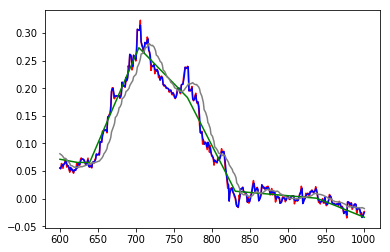

In [78]:
import matplotlib.pyplot as plt

plt.plot(master['Ratio'][600:1000+m], color='red')
plt.plot(master['Past_Sharpe4'][600:1000+m],color='blue')
plt.plot(master['Ratio_smoothed'][600:1000+m], color = 'green')
plt.plot(master['Label3_Sharpe'][600:1000+m], color='gray')

## Adding Rules